${\Huge \textbf{Testing the U2H map in the Lofoten Eddy}}$  
${\small \textbf{Maturin SIMONNEAU}}$

In [1]:
import hwffts
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc
from scipy import special   
import pickle
from scipy import integrate
import warnings
pi=np.pi
import xarray as xr
import SWOT_tools as st
from U2H import U2H
import matplotlib.patches as patches

%matplotlib inline

In [2]:
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})

import matplotlib.font_manager as fm
# Regular and bold font paths
font_regular_path = "fonts/times/times.ttf"
font_bold_path = "fonts/times/timesbd.ttf"  # Bold
# Register both fonts
fm.fontManager.addfont(font_regular_path)
fm.fontManager.addfont(font_bold_path)
# Create font properties
font_regular = fm.FontProperties(fname=font_regular_path)
font_bold = fm.FontProperties(fname=font_bold_path)
# Set default font to regular Times New Roman
plt.rcParams['font.family'] = font_regular.get_name()

In [3]:
####################
# AREA OF INTEREST #
####################

#lon_map_min, lon_map_max, lat_map_min, lat_map_max = -8, 12, 67, 73
lon_map_min, lon_map_max, lat_map_min, lat_map_max = -2, 12, 67, 72

# Launching Currents (VarDYn & Globcurrent)

/dev/shm/pbs.3818094.datarmor0/ipykernel_10585/2180875682.py:63: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X_grid, Y_grid, np.sqrt(u_vd.values**2+v_vd.values**2), cmap=cc.cm.fire)


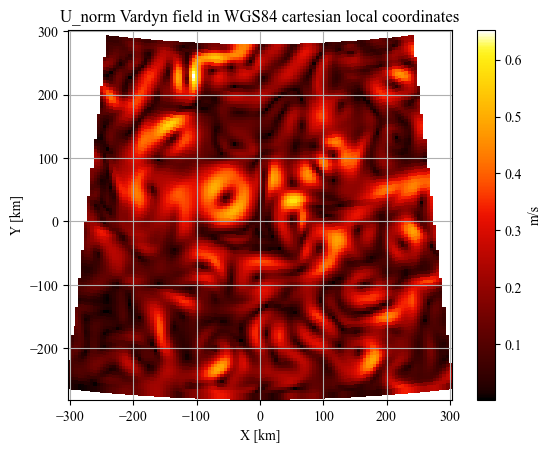

lon_grid: (112, 121)
lat_grid: (112, 121)
lon_grid: (112, 120)
lat_grid: (112, 120)
n_x_centered: (120,)
n_y_centered: (112,)


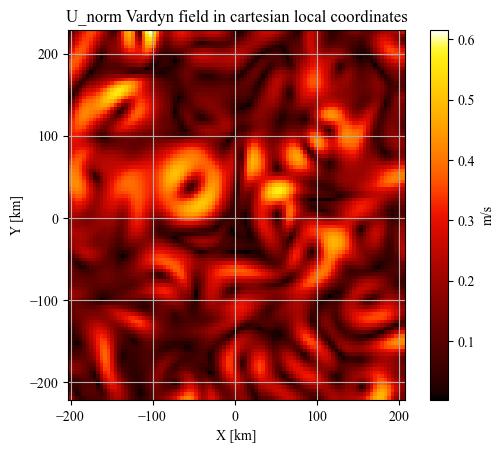

In [4]:
##############
### Vardyn ###
##############

### Launching ###

# Vardyn
new_file = True

if new_file:
    ds_vardyn = xr.open_dataset(r"data/vardyn/2025/129/VarDyn_Lofoten_SWOT_allNadirs.nc")
    ds_vardyn = ds_vardyn.isel(time=153)
    ds_vardyn = ds_vardyn.where((ds_vardyn.lon >= lon_map_min) & (ds_vardyn.lon <= lon_map_max) & (ds_vardyn.lat>= lat_map_min) & (ds_vardyn.lat <= lat_map_max), drop=True)
    lon_vd_grid = ds_vardyn.lon.values # shape (113, 175)
    lat_vd_grid = ds_vardyn.lat.values # shape (113, 175)
    u_vd = ds_vardyn.u
    v_vd = ds_vardyn.v
    norm_U_vd = 100*np.sqrt(u_vd**2 + v_vd**2) 


else:
    ds_vardyn = xr.open_dataset(r"/home1/datawork/msimonne/LE_20250509/vardyn/vardyn_otc2025_20250509000000_L4_v1.0_fv1.0/vardyn_otc2025_20250509000000_L4_v1.0_fv1.0_idf_00.nc")
    ds_vardyn = ds_vardyn.sel(lon_gcp=slice(lon_map_min,lon_map_max), lat_gcp = slice(lat_map_min,lat_map_max))
    
    idx_lon_min, idx_lon_max = np.min(ds_vardyn.index_lon_gcp), np.max(ds_vardyn.index_lon_gcp)
    idx_lat_min, idx_lat_max = np.min(ds_vardyn.index_lat_gcp), np.max(ds_vardyn.index_lat_gcp)
    ds_vardyn = ds_vardyn.isel(lon=slice(int(idx_lon_min),int(idx_lon_max)+1), lat = slice(int(idx_lat_min),int(idx_lat_max)+1))
    
    lon_vd = np.array([round(round(float(ds_vardyn.lon_gcp.values[0]),2) + 0.1*k,2) for k in range(len(ds_vardyn.lon))])
    lat_vd = np.array([round(round(float(ds_vardyn.lat_gcp.values[0]),2) + 0.1*k,2) for k in range(len(ds_vardyn.lat))])
    lon_vd_grid, lat_vd_grid = np.meshgrid(lon_vd, lat_vd)

    u_vd = ds_vardyn.u.isel(time=0) # Sinon on a 5 dimensions
    v_vd = ds_vardyn.v.isel(time=0) # Sinon on a 5 dimensions
    norm_U_vd = 100*np.sqrt(u_vd**2 + v_vd**2) 

# ancien truc qui a bug, je vais bientôt le virer si le truc du dessus marche
"""
ds_vardyn = xr.open_dataset(r"/home1/datawork/msimonne/LE_20250509/vardyn/vardyn_otc2025_20250509000000_L4_v1.0_fv1.0/vardyn_otc2025_20250509000000_L4_v1.0_fv1.0_idf_00.nc")
ds_vardyn = ds_vardyn.where((ds_vardyn.lon_gcp >= lon_map_min) & (ds_vardyn.lon_gcp <= lon_map_max) & (ds_vardyn.lat_gcp >= lat_map_min) & (ds_vardyn.lat_gcp <= lat_map_max), drop=True)
idx_lon_min, idx_lon_max = np.min(ds_vardyn.index_lon_gcp), np.max(ds_vardyn.index_lon_gcp)
idx_lat_min, idx_lat_max = np.min(ds_vardyn.index_lat_gcp), np.max(ds_vardyn.index_lat_gcp)
ds_vardyn = ds_vardyn.where((ds_vardyn.lon >= idx_lon_min) & (ds_vardyn.lon <= idx_lon_max) & (ds_vardyn.lat >= idx_lat_min) & (ds_vardyn.lat <= idx_lat_max), drop=True)

lon_vd = np.array([round(round(float(ds_vardyn.lon_gcp.values[0]),2) + 0.1*k,2) for k in range(len(ds_vardyn.lon))])
lat_vd = np.array([round(round(float(ds_vardyn.lat_gcp.values[0]),2) + 0.1*k,2) for k in range(len(ds_vardyn.lat))])
lon_vd_grid, lat_vd_grid = np.meshgrid(lon_vd, lat_vd)

u_vd = ds_vardyn.u.isel(time=0, lon_gcp=0, lat_gcp=0) # Sinon on a 5 dimensions
v_vd = ds_vardyn.v.isel(time=0, lon_gcp=0, lat_gcp=0) # Sinon on a 5 dimensions
norm_U_vd = 100*np.sqrt(u_vd**2 + v_vd**2) 
"""

### Projecting in Mercator from WGS84 coordinates ### 

middle_idx_x, middle_idx_y = lon_vd_grid.shape[1]//2, lon_vd_grid.shape[0]//2
lon0, lat0 = lon_vd_grid[middle_idx_y, middle_idx_x], lat_vd_grid[middle_idx_y, middle_idx_x]
#lon0, lat0 = 2, 70
lon0, lat0 = 5, 69.5

X_grid, Y_grid = st.wgs84_to_local_km(lon_vd_grid, lat_vd_grid, lon0, lat0)
plt.title("U_norm Vardyn field in WGS84 cartesian local coordinates")
plt.pcolormesh(X_grid, Y_grid, np.sqrt(u_vd.values**2+v_vd.values**2), cmap=cc.cm.fire)
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="m/s")
plt.show()

# On récupère x1d, y1d
x_grid_spheric, y_grid_spheric, dx, dy, x1d, y1d = st.lonlat2XYspheric(lon_vd_grid, lat_vd_grid)

x_grid, y_grid = np.meshgrid(x1d, y1d)

### Maintenant on interpole
from scipy.interpolate import griddata
#points = np.concatenate((x_grid_spheric.flatten().reshape(-1,1), y_grid_spheric.flatten().reshape(-1,1)),axis=1) # shape (n, 2): c'est les coordonnées des points en coordonnées sphériques 
points = np.concatenate((X_grid.flatten().reshape(-1,1), Y_grid.flatten().reshape(-1,1)),axis=1) # shape (n, 2): c'est les coordonnées des points en coordonnées sphériques 
#interpolated_values_on_grid = griddata(points, values, (grid_x, grid_y), method='linear') # ligne de code pour se rappeler comment ça marche
u_vd_c = griddata(points, u_vd.values.flatten(), (x_grid, y_grid), method='linear')
v_vd_c = griddata(points, v_vd.values.flatten(), (x_grid, y_grid), method='linear')

plt.title("U_norm Vardyn field in cartesian local coordinates")
plt.pcolormesh(x_grid, y_grid, np.sqrt(u_vd_c**2+v_vd_c**2), cmap=cc.cm.fire)
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="m/s")
plt.show()

/dev/shm/pbs.3818094.datarmor0/ipykernel_10585/767999493.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X_grid, Y_grid, np.sqrt(uo**2+vo**2), cmap=cc.cm.fire)


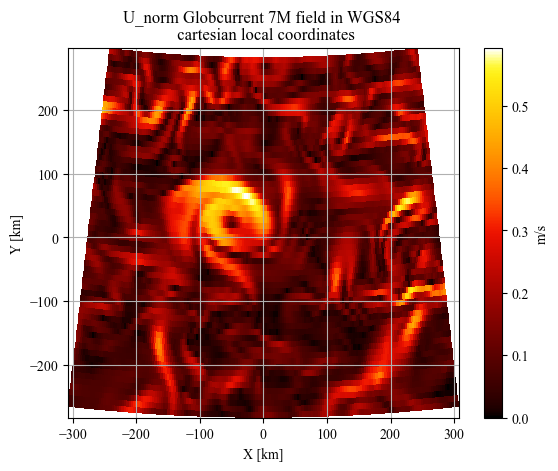

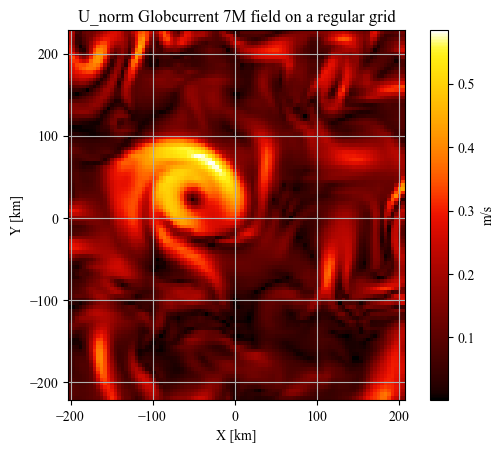

5 69.5


In [5]:
########################
# MERCATOR GLOBCURRENT #
########################

### Launching ###

ds_cur = xr.open_dataset(r"data/globcurrent/merca_globcur_20250509.nc")
ds_cur = ds_cur.where((ds_cur.longitude >= lon_map_min) & (ds_cur.longitude <= lon_map_max) & (ds_cur.latitude >= lat_map_min) & (ds_cur.latitude <= lat_map_max), drop=True)
lon_cur, lat_cur = ds_cur.longitude.values, ds_cur.latitude.values
lon_cur2D, lat_cur2D = np.meshgrid(lon_cur, lat_cur)
uo, vo = ds_cur.uo.values, ds_cur.vo.values

### Projecting in Mercator from WGS84 coordinates ### 

middle_idx_x, middle_idx_y = lon_cur2D.shape[1]//2, lon_cur2D.shape[0]//2
#lon0, lat0 = lon_cur2D[middle_idx_y, middle_idx_x], lat_cur2D[middle_idx_y, middle_idx_x]
X_grid, Y_grid = st.wgs84_to_local_km(lon_cur2D, lat_cur2D, lon0, lat0)
plt.title("U_norm Globcurrent 7M field in WGS84 \n cartesian local coordinates")
plt.pcolormesh(X_grid, Y_grid, np.sqrt(uo**2+vo**2), cmap=cc.cm.fire)
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="m/s")
plt.show()
# On récupère x1d, y1d
#x_grid_spheric, y_grid_spheric, dx, dy, x1d, y1d = st.lonlat2XYspheric(lon_vd_grid, lat_vd_grid)

#x_grid, y_grid = np.meshgrid(x1d, y1d)

### Maintenant on interpole
from scipy.interpolate import griddata
#points = np.concatenate((x_grid_spheric.flatten().reshape(-1,1), y_grid_spheric.flatten().reshape(-1,1)),axis=1) # shape (n, 2): c'est les coordonnées des points en coordonnées sphériques 
points = np.concatenate((X_grid.flatten().reshape(-1,1), Y_grid.flatten().reshape(-1,1)),axis=1) # shape (n, 2): c'est les coordonnées des points en coordonnées sphériques 
#interpolated_values_on_grid = griddata(points, values, (grid_x, grid_y), method='linear') # ligne de code pour se rappeler comment ça marche
uo_c = griddata(points, uo.flatten(), (x_grid, y_grid), method='linear')
vo_c = griddata(points, vo.flatten(), (x_grid, y_grid), method='linear')


plt.title("U_norm Globcurrent 7M field on a regular grid")
plt.pcolormesh(x_grid, y_grid, np.sqrt(uo_c**2+vo_c**2), cmap=cc.cm.fire)
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="m/s")
plt.show()


print(lon0, lat0)

# Launching WAVEWATCH III (Without and with Globcurrent as a forcing)

/dev/shm/pbs.3818094.datarmor0/ipykernel_10585/2739601920.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X_grid, Y_grid, hs_no_cur, cmap="jet")


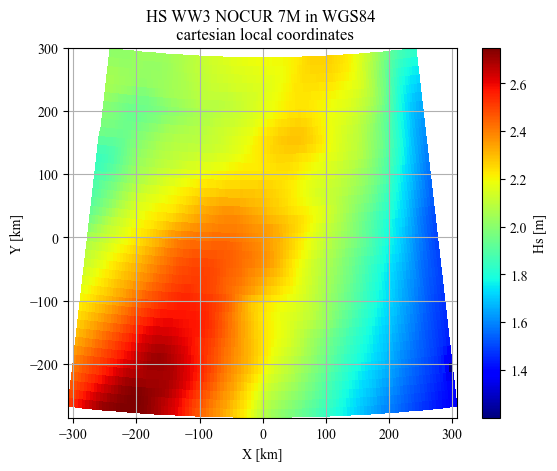

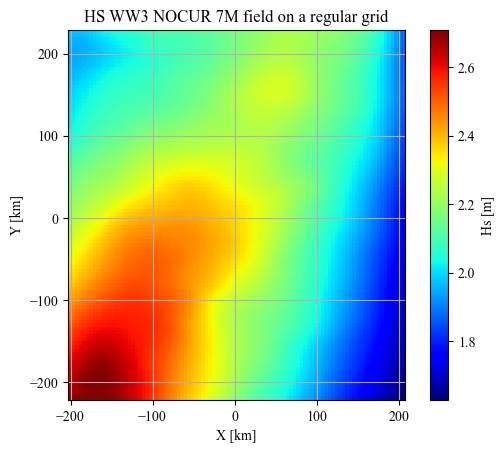

5 69.5


In [6]:
########################
# WAVEWATCH III no_cur #
########################
#%matplotlib inline
### Launching ###

ds_ww3_7M_no_cur =  xr.open_dataset(r"data/ww3/2025/129/SWOT_WW3-GLOB-7M_NOCUR_20250509.nc")

ds_ww3_7M_no_cur = ds_ww3_7M_no_cur.isel(time=9)
ds_ww3_7M_no_cur = ds_ww3_7M_no_cur.where((ds_ww3_7M_no_cur.longitude >= lon_map_min) & (ds_ww3_7M_no_cur.longitude <= lon_map_max) & (ds_ww3_7M_no_cur.latitude >= lat_map_min) & (ds_ww3_7M_no_cur.latitude <= lat_map_max), drop=True)


lon_no_cur = ds_ww3_7M_no_cur.longitude.values
lat_no_cur = ds_ww3_7M_no_cur.latitude.values
hs_no_cur = ds_ww3_7M_no_cur.hs.values
lon_no_cur2D, lat_no_cur2D = np.meshgrid(lon_no_cur, lat_no_cur)

### Projecting in Mercator from WGS84 coordinates ### 

middle_idx_x, middle_idx_y = lon_no_cur2D.shape[1]//2, lon_no_cur2D.shape[0]//2
#lon0, lat0 = lon_no_cur2D[middle_idx_y, middle_idx_x], lat_no_cur2D[middle_idx_y, middle_idx_x]
X_grid, Y_grid = st.wgs84_to_local_km(lon_no_cur2D, lat_no_cur2D, lon0, lat0)

plt.clf()
plt.title("HS WW3 NOCUR 7M in WGS84 \n cartesian local coordinates")
plt.pcolormesh(X_grid, Y_grid, hs_no_cur, cmap="jet")
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="Hs [m]")
plt.show()

### Maintenant on interpole
from scipy.interpolate import griddata
#points = np.concatenate((x_grid_spheric.flatten().reshape(-1,1), y_grid_spheric.flatten().reshape(-1,1)),axis=1) # shape (n, 2): c'est les coordonnées des points en coordonnées sphériques 
points = np.concatenate((X_grid.flatten().reshape(-1,1), Y_grid.flatten().reshape(-1,1)),axis=1) # shape (n, 2): c'est les coordonnées des points en WGS84 local km
#interpolated_values_on_grid = griddata(points, values, (grid_x, grid_y), method='linear') # ligne de code pour se rappeler comment ça marche
hs_no_cur_c = griddata(points, hs_no_cur.flatten(), (x_grid, y_grid), method='linear')

plt.clf()
plt.title("HS WW3 NOCUR 7M field on a regular grid")
plt.pcolormesh(x_grid, y_grid, hs_no_cur_c, cmap="jet")
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="Hs [m]")
plt.show()


print(lon0, lat0)


/dev/shm/pbs.3818094.datarmor0/ipykernel_10585/80630214.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X_grid, Y_grid, hs_cur, cmap="jet")


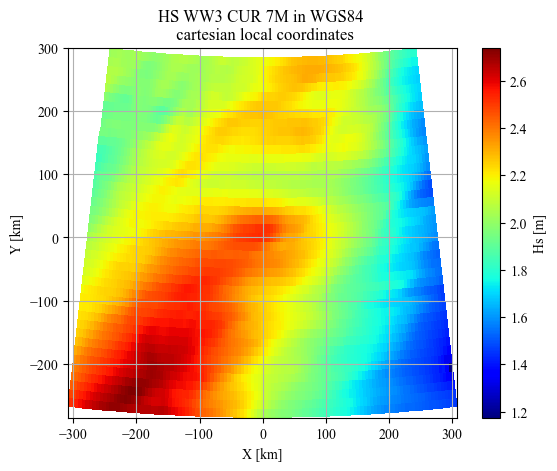

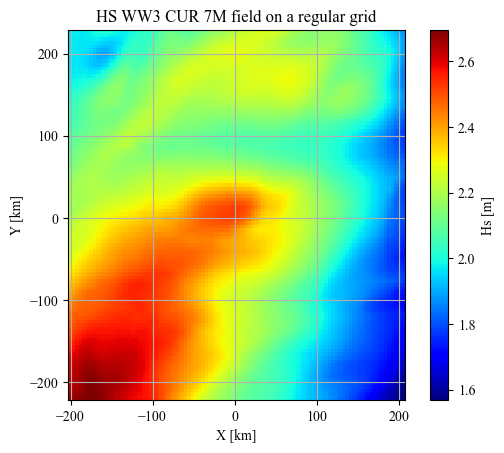

5 69.5


In [7]:
#####################
# WAVEWATCH III cur #
#####################

### Launching ###

ds_ww3_7M_cur =  xr.open_dataset(r"data/ww3/2025/129/SWOT_WW3-GLOB-7M_CUR_20250509.nc")

ds_ww3_7M_cur = ds_ww3_7M_cur.isel(time=9)
ds_ww3_7M_cur = ds_ww3_7M_cur.where((ds_ww3_7M_cur.longitude >= lon_map_min) & (ds_ww3_7M_cur.longitude <= lon_map_max) & (ds_ww3_7M_cur.latitude >= lat_map_min) & (ds_ww3_7M_cur.latitude <= lat_map_max), drop=True)


lon_cur = ds_ww3_7M_cur.longitude.values
lat_cur = ds_ww3_7M_cur.latitude.values
hs_cur = ds_ww3_7M_cur.hs.values
lon_cur2D, lat_cur2D = np.meshgrid(lon_cur, lat_cur)

### Projecting in Mercator from WGS84 coordinates ### 

middle_idx_x, middle_idx_y = lon_cur2D.shape[1]//2, lon_cur2D.shape[0]//2
#lon0, lat0 = lon_cur2D[middle_idx_y, middle_idx_x], lat_cur2D[middle_idx_y, middle_idx_x]
X_grid, Y_grid = st.wgs84_to_local_km(lon_cur2D, lat_cur2D, lon0, lat0)
plt.title("HS WW3 CUR 7M in WGS84 \n cartesian local coordinates")
plt.pcolormesh(X_grid, Y_grid, hs_cur, cmap="jet")
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="Hs [m]")
plt.show()

### Maintenant on interpole
points = np.concatenate((X_grid.flatten().reshape(-1,1), Y_grid.flatten().reshape(-1,1)),axis=1) # shape (n, 2): c'est les coordonnées des points en WGS84 local km
#interpolated_values_on_grid = griddata(points, values, (grid_x, grid_y), method='linear') # ligne de code pour se rappeler comment ça marche
hs_cur_c = griddata(points, hs_cur.flatten(), (x_grid, y_grid), method='linear')

plt.clf()
plt.title("HS WW3 CUR 7M field on a regular grid")
plt.pcolormesh(x_grid, y_grid, hs_cur_c, cmap="jet")
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="Hs [m]")
plt.show()


print(lon0, lat0)

# Launching SWOT (and interpolate on U2H grid)

Start SWOT: 09/05/2025 08:43:37
End SWOT: 09/05/2025 08:45:37
lon0, lat0
5 69.5


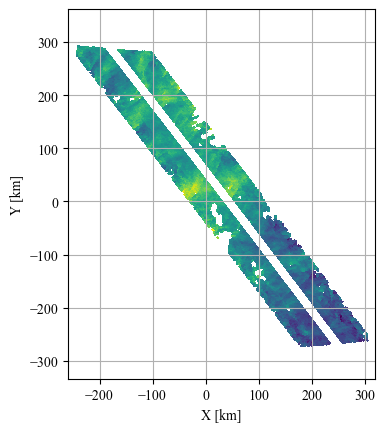

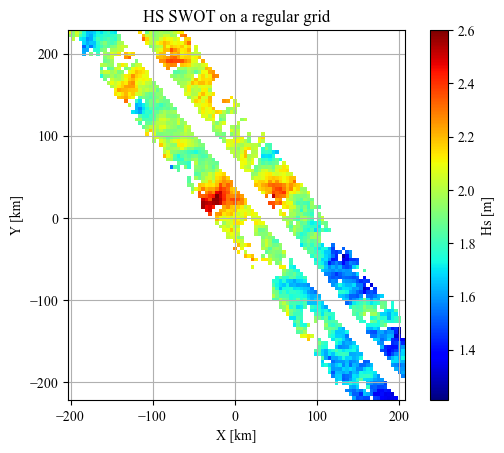

In [8]:
####################
### LOADING SWOT ###
####################

### Launching ###


ds_swot = xr.open_dataset(r"data/swot/2025/129/SWOT_L2_LR_SSH_WindWave_032_318_20250509T083955_20250509T093123_PID0_01.nc")
#ds_swot = xr.open_dataset(r"/home1/datawork/msimonne/data/swot/Expert/2025/129/SWOT_L2_LR_SSH_Expert_032_318_20250509T083955_20250509T093123_PID0_01.nc")
ds_swot, t_ini_swot_formatted, t_end_swot_formatted = st.format_ds_swot(ds_swot, lon_map_min, lon_map_max, lat_map_min, lat_map_max, untrustable_hs=2.75, kernel_size_nan=7, step_to_crop_at_edges=2)
print("Start SWOT:", t_ini_swot_formatted)
print("End SWOT:", t_end_swot_formatted)

num_lines_swot = ds_swot.longitude.values.shape[0]
if num_lines_swot % 2 == 1:
    ds_swot = ds_swot.isel(num_lines=slice(0,num_lines_swot-1))
ds_swot = ds_swot.isel(num_pixels=slice(0,68)) # Parce que il y a toujours 69 colonnes
ds_swot.longitude.values.shape

lon_swot = ds_swot.longitude.values
lat_swot = ds_swot.latitude.values
hs_swot = ds_swot.swh_karin.values

### Projecting in Mercator from WGS84 coordinates ### 


middle_idx_x, middle_idx_y = lon_vd_grid.shape[1]//2, lon_vd_grid.shape[0]//2

lon_swot0, lat_swot0 = lon_vd_grid[middle_idx_y, middle_idx_x], lat_vd_grid[middle_idx_y, middle_idx_x]
lon_swot0, lat_swot0 = lon0, lat0
print("lon0, lat0")
print(lon_swot0, lat_swot0)


X_swot, Y_swot = st.wgs84_to_local_km(lon_swot, lat_swot, lon_swot0, lat_swot0)

plt.pcolor(X_swot,Y_swot,hs_swot)
plt.axis("scaled")
plt.grid()
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.show()

### Maintenant on interpole
points = np.concatenate((X_swot.flatten().reshape(-1,1), Y_swot.flatten().reshape(-1,1)),axis=1) # shape (n, 2): c'est les coordonnées des points en WGS84 local km
#interpolated_values_on_grid = griddata(points, values, (grid_x, grid_y), method='linear') # ligne de code pour se rappeler comment ça marche
hs_swot_c = griddata(points, hs_swot.flatten(), (x_grid, y_grid), method='linear')

plt.clf()
plt.title("HS SWOT on a regular grid")
plt.pcolormesh(x_grid, y_grid, hs_swot_c, cmap="jet")
plt.xlabel("X [km]")
plt.ylabel("Y [km]")
plt.axis('scaled')
plt.grid()
plt.colorbar(label="Hs [m]")
plt.show()


# Compute the U2H map

In [9]:
########################
# U2H INPUT PARAMETERS #
########################

#Whether or not the incoming wave spectrum follows the LHCS model spectrum described in Appendix B, with the directional-width parameter $s$ assumed to be an integer. 
#By default this is set True, as the default example presented here is the same as figure 1, which satisfies the LHCS with $\theta_p=0, s=10$.
#If your incoming wave spectrum is not LHCS with integer s, then please set isLHCSisimp=False, and determine ncutoff in cell [5]. The demonstration in cell [7] on the asymptotic approximation of the U2H map under the swell limit are not implemented when this is False.  
isLHCSsimp=True

#Parameters for the incoming wave spectra assuming the LHCS model described in Appendix B. Default values correspond to the snapshot shown in Figure 1 of our paper. 
#If not assuming the LHCS model, you can caption out the next lines in this code block and define your own E2D. 
waveT=6.8 #Peak wave period (unit: s)
s=10 #Directional spreading parameter in the LHCS model; larger s correspond to smaller directional spreading
sip = 0.01#0.01 #variance of frequency
# theta_p=12*pi/180 #primary angle of wave propagation, measured from the $x$-axis and in the direction of $\bk$. Unit: radians. 
wave_dir_from = 235 # in degrees, direction from North in usual heading convention direction
wave_dir_from = 250

Hs0=np.nanmean(hs_swot) #Background significant wave height (unit: m). This parameter does not affect the outcomes presented in terms of hs/Hs0
print("Hs0 from SWOT [m]:", Hs0)

Hs0 from SWOT [m]: 1.8477611066773076


In [10]:
### VarDyn ###
u, v = u_vd_c.T, v_vd_c.T 
Hs_vd, hs_over_Hs0_vd = U2H(u, v, x1d, y1d, waveT, wave_dir_from, s, sip, Hs0, Ndir=48, Nf=32, isLHCSsimp=True)
current_name = "VarDyn"

"""
### Mercator ###
u, v = uo_c.T, vo_c.T 
Hs_gbc, hs_over_Hs0_gbc = U2H(u, v, x1d, y1d, waveT, wave_dir_from, s, sip, Hs0, Ndir=48, Nf=32, isLHCSsimp=True)
current_name = "GLOBCURRENT 7M"
"""

Parameter 'ncutoff' is given as 10.


'\n### Mercator ###\nu, v = uo_c.T, vo_c.T \nHs_gbc, hs_over_Hs0_gbc = U2H(u, v, x1d, y1d, waveT, wave_dir_from, s, sip, Hs0, Ndir=48, Nf=32, isLHCSsimp=True)\ncurrent_name = "GLOBCURRENT 7M"\n'

# Plotting part

Plotting the snapshot of the current speed and the hs computed from the U2H map. Under default configurations, this corresponds to the panels (a,b) of figure 1 in the paper.

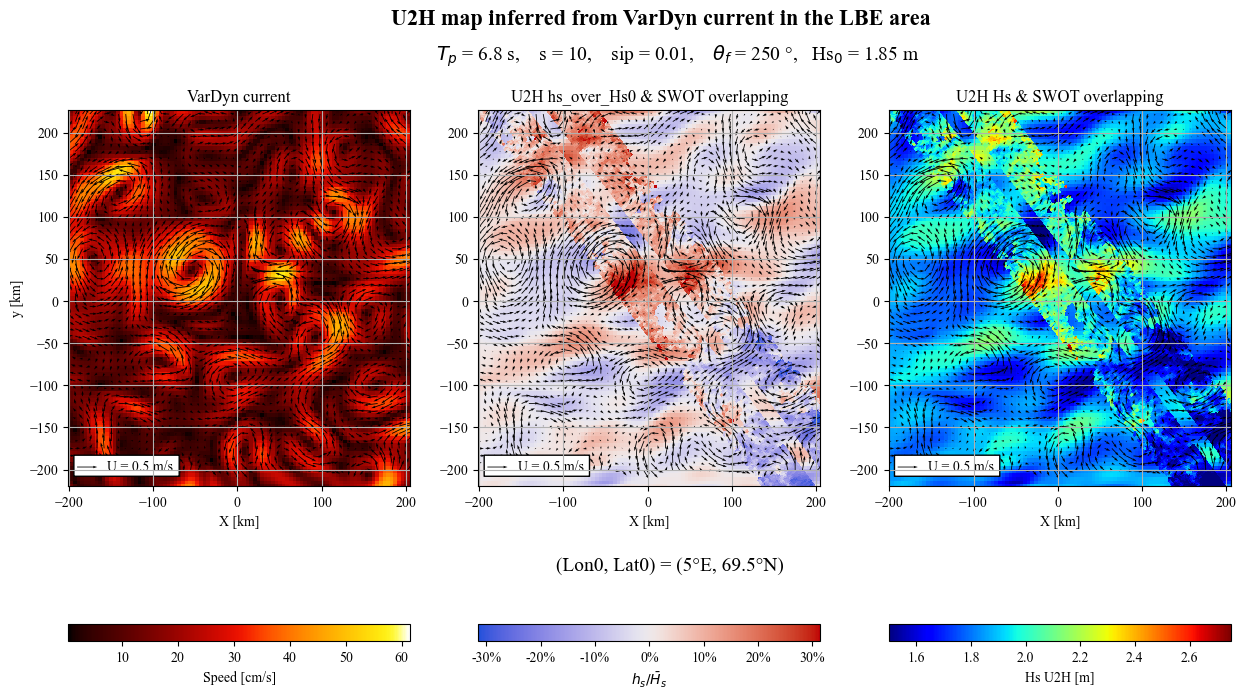

In [11]:
"""
%matplotlib widget
from matplotlib.widgets import Slider
"""
fighs,axhsall=plt.subplots(1,3, figsize=(15,12))
axhs=axhsall.ravel()


#hsa_max=np.nanmax(np.abs(hs_over_Hs0_gbc))
hsa_max=np.nanmax(np.abs(hs_over_Hs0_vd))
hsa_min=-hsa_max

#Hs_max = np.nanmax(Hs_gbc)
#Hs_min = np.nanmin(Hs_gbc)

Hs_max = 2.75 #np.nanmax(Hs_vd)
Hs_min = 1.5 # np.nanmin(Hs_vd)

uspeed=np.sqrt(u.T**2+v.T**2)

max_mag_vd = np.nanmax(uspeed)
arrow_length = 0.02*3.62
scale_vd = max_mag_vd / arrow_length

#The 2D fields are transposed for plotting 
imu=axhs[0].pcolor(x_grid,y_grid,uspeed*100,cmap=cc.cm.fire) 
imhs=axhs[1].pcolor(x_grid,y_grid,hs_over_Hs0_vd*100,cmap=cc.cm.coolwarm,vmax=hsa_max*100,vmin=hsa_min*100,shading="nearest") 
imhsu2h = axhs[2].pcolor(x_grid,y_grid, Hs_vd, vmin=Hs_min, vmax=Hs_max, cmap='jet')#,vmax=hsa_max*100,vmin=hsa_min*100) 

show_swot = True
if show_swot:
    hs_swot_relative = 100*(hs_swot / np.nanmean(hs_swot) - 1) # - 1, comme ça si hs_swot = mean(hs_swot), ça fait 0%
    imsw1 = axhs[1].pcolor(X_swot, Y_swot, hs_swot_relative, cmap=cc.cm.coolwarm, vmax=hsa_max*100, vmin=hsa_min*100, alpha=1)
    imsw2 = axhs[2].pcolor(X_swot, Y_swot, hs_swot, cmap="jet", vmin=Hs_min, vmax=Hs_max, alpha=1)


step_vd = 2
for i in [0,1,2]:
    q = axhs[i].quiver(x_grid[2*step_vd::step_vd,::step_vd], y_grid[2*step_vd::step_vd,::step_vd], u.T[2*step_vd::step_vd,::step_vd], v.T[2*step_vd::step_vd,::step_vd], color="black", label="Vardyn Direction", scale=scale_vd)
    # Add a quiver key to indicate vector scale

    rect = patches.FancyBboxPatch(
    (-194, -208),  # bottom left corner in data coords
    width=125, height=25, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
    axhs[i].add_patch(rect)
    
    axhs[i].quiverkey(q, X=0.085, Y=0.05, U=0.5,label='U = 0.5 m/s ', labelpos='E')

#cbarhs_sw = plt.colorbar(imsw, label = "Hs SWOT [m]")

for i in range(3):
    axhs[i].set_xlim(np.min(x_grid),np.max(x_grid))
    axhs[i].set_ylim(np.min(y_grid),np.max(y_grid))
    axhs[i].set_aspect('equal')
    axhs[i].set_xlabel('X [km]')
    axhs[i].grid()
    


axhs[0].set_title(f'{current_name} current' )
axhs[1].set_title(r'U2H hs_over_Hs0 & SWOT overlapping')
axhs[2].set_title(r'U2H Hs & SWOT overlapping')
axhs[0].set_ylabel('y [km]')
#axhs[1].tick_params(labelleft=False)    


cbaru=plt.colorbar(imu, label='Speed [cm/s]', orientation='horizontal')
cbarhs=plt.colorbar(imhs, label=r'$h_s/\bar{H}_s$', orientation='horizontal',format ='%.0f%%')
cbarhsu2h=plt.colorbar(imhsu2h, label='Hs U2H [m]', orientation='horizontal')

fighs.text(x=0.45, y=0.27, s=f"(Lon0, Lat0) = ({lon0}°E, {lat0}°N)", fontsize = 14) 
fighs.text(x=0.37, y=0.695, s=r"$T_p$ = {} s,    s = {},    sip = {},    $\theta _f$ = {} °,   Hs$_0$ = {} m".format(waveT, s, sip, wave_dir_from, round(Hs0,2)), fontsize = 14)

"""
# Create the slider
slider_ax_1 = fighs.add_axes([0.41, 0.1, 0.2, 0.03])

alpha_slider_1 = Slider(ax=slider_ax_1, label=r"$\alpha$: transparency", valmin=0.0, valmax=1.0, valinit=0.99)
# Define the update function
def update_alpha_1(val):
    imsw1.set_alpha(val)
    imsw2.set_alpha(val)
    fighs.canvas.draw_idle()

# Connect the slider to the update function
alpha_slider_1.on_changed(update_alpha_1)
"""

fighs.text(x=0.34, y=0.725, s=f'U2H map inferred from {current_name} current in the LBE area', fontproperties=font_bold, fontsize=16) 

plt.savefig("output_images/LF/U2H_LBE.png")
plt.show()


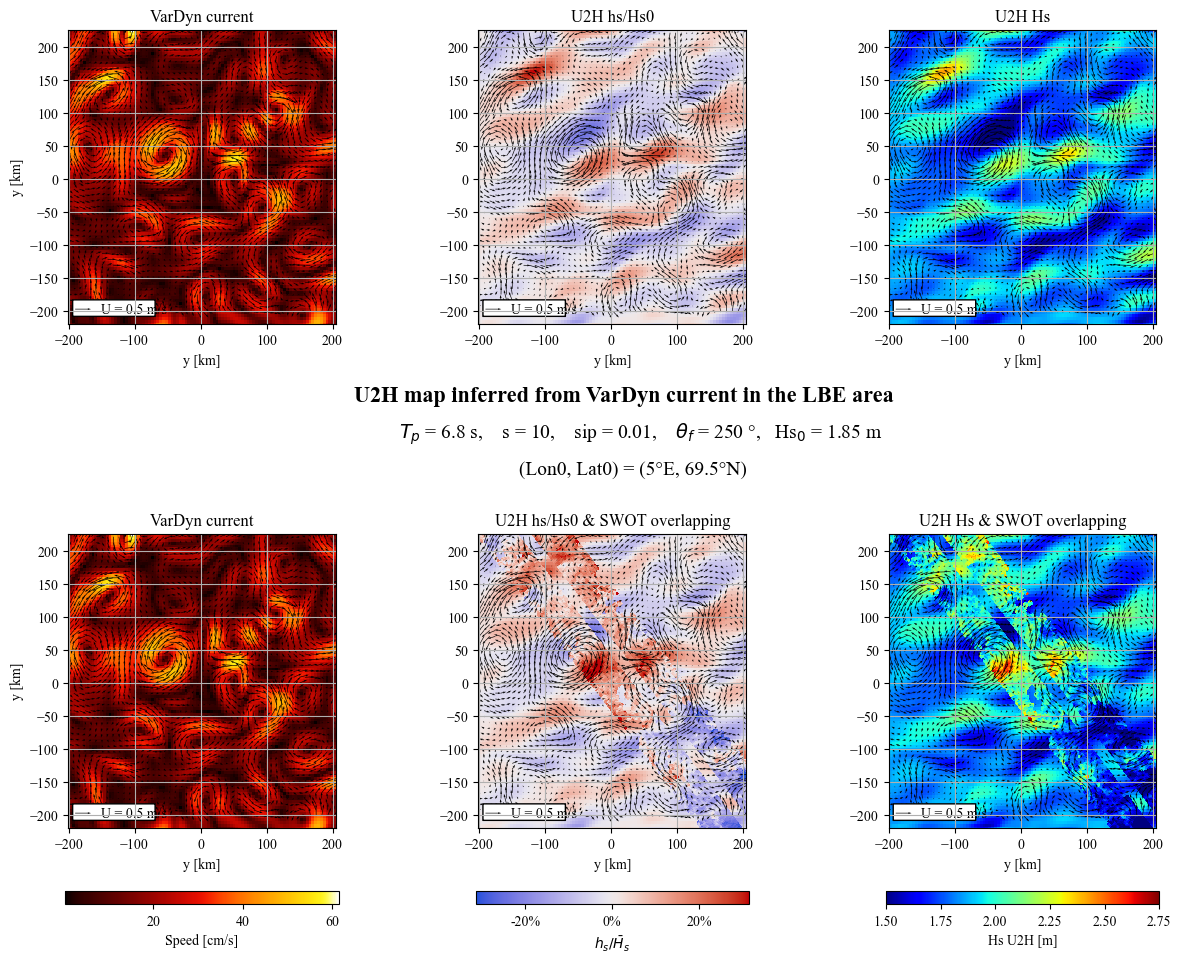

In [13]:
"""
%matplotlib widget
from matplotlib.widgets import Slider
"""
fighs,axhsall=plt.subplots(2,3, figsize=(15,12))
axhs=axhsall.ravel()


#hsa_max=np.nanmax(np.abs(hs_over_Hs0_gbc))
hsa_max=np.nanmax(np.abs(hs_over_Hs0_vd))
hsa_min=-hsa_max

#Hs_max = np.nanmax(Hs_gbc)
#Hs_min = np.nanmin(Hs_gbc)

Hs_max = 2.75 #np.nanmax(Hs_vd)
Hs_min = 1.5 # np.nanmin(Hs_vd)

uspeed=np.sqrt(u.T**2+v.T**2)

max_mag_vd = np.nanmax(uspeed)
arrow_length = 0.02*3.62
scale_vd = max_mag_vd / arrow_length

#The 2D fields are transposed for plotting 
imu=axhs[0].pcolor(x_grid,y_grid,uspeed*100,cmap=cc.cm.fire) 
imhs=axhs[1].pcolor(x_grid,y_grid,hs_over_Hs0_vd*100,cmap=cc.cm.coolwarm,vmax=hsa_max*100,vmin=hsa_min*100,shading="nearest") 
imhsu2h = axhs[2].pcolor(x_grid,y_grid, Hs_vd, vmin=Hs_min, vmax=Hs_max, cmap='jet')#,vmax=hsa_max*100,vmin=hsa_min*100) 

for i, im in enumerate([imu,imhs,imhsu2h]):
    # Create colorbar, but invisible to keep spacing between subplots
    cbar = plt.colorbar(im, ax=axhs[i], alpha=0.2, orientation='horizontal')
    cbar.ax.clear()                   # wipes the color mesh and ticks
    cbar.outline.set_visible(False)
    cbar.set_ticks([])           # Remove ticks
    cbar.ax.set_xticks([])
    cbar.ax.set_yticks([])

show_swot = False
if show_swot:
    hs_swot_relative = 100*(hs_swot / np.nanmean(hs_swot) - 1) # - 1, comme ça si hs_swot = mean(hs_swot), ça fait 0%
    imsw1 = axhs[1].pcolor(X_swot, Y_swot, hs_swot_relative, cmap=cc.cm.coolwarm, vmax=hsa_max*100, vmin=hsa_min*100, alpha=1)
    imsw2 = axhs[2].pcolor(X_swot, Y_swot, hs_swot, cmap="jet", vmin=Hs_min, vmax=Hs_max, alpha=1)


step_vd = 2
for i in [0,1,2]:
    q = axhs[i].quiver(x_grid[2*step_vd::step_vd,::step_vd], y_grid[2*step_vd::step_vd,::step_vd], u.T[2*step_vd::step_vd,::step_vd], v.T[2*step_vd::step_vd,::step_vd], color="black", label="Vardyn Direction", scale=scale_vd)
    # Add a quiver key to indicate vector scale

    rect = patches.FancyBboxPatch(
    (-194, -208),  # bottom left corner in data coords
    width=125, height=25, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
    axhs[i].add_patch(rect)
    
    axhs[i].quiverkey(q, X=0.085, Y=0.05, U=0.5,label='U = 0.5 m/s ', labelpos='E')


#The 2D fields are transposed for plotting 
imu=axhs[3].pcolor(x_grid,y_grid,uspeed*100,cmap=cc.cm.fire) 
imhs=axhs[4].pcolor(x_grid,y_grid,hs_over_Hs0_vd*100,cmap=cc.cm.coolwarm,vmax=hsa_max*100,vmin=hsa_min*100,shading="nearest") 
imhsu2h = axhs[5].pcolor(x_grid,y_grid, Hs_vd, vmin=Hs_min, vmax=Hs_max, cmap='jet')#,vmax=hsa_max*100,vmin=hsa_min*100) 

show_swot = True
if show_swot:
    hs_swot_relative = 100*(hs_swot / np.nanmean(hs_swot) - 1) # - 1, comme ça si hs_swot = mean(hs_swot), ça fait 0%
    imsw1 = axhs[4].pcolor(X_swot, Y_swot, hs_swot_relative, cmap=cc.cm.coolwarm, vmax=hsa_max*100, vmin=hsa_min*100, alpha=1)
    imsw2 = axhs[5].pcolor(X_swot, Y_swot, hs_swot, cmap="jet", vmin=Hs_min, vmax=Hs_max, alpha=1)


step_vd = 2
for i in [3,4,5]:
    q = axhs[i].quiver(x_grid[2*step_vd::step_vd,::step_vd], y_grid[2*step_vd::step_vd,::step_vd], u.T[2*step_vd::step_vd,::step_vd], v.T[2*step_vd::step_vd,::step_vd], color="black", label="Vardyn Direction", scale=scale_vd)
    # Add a quiver key to indicate vector scale

    rect = patches.FancyBboxPatch(
    (-194, -208),  # bottom left corner in data coords
    width=125, height=25, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
    axhs[i].add_patch(rect)
    
    axhs[i].quiverkey(q, X=0.085, Y=0.05, U=0.5,label='U = 0.5 m/s ', labelpos='E')

#cbarhs_sw = plt.colorbar(imsw, label = "Hs SWOT [m]")

for i in range(6):
    axhs[i].set_xlim(np.min(x_grid),np.max(x_grid))
    axhs[i].set_ylim(np.min(y_grid),np.max(y_grid))
    axhs[i].set_aspect('equal')
    axhs[i].set_xlabel('x [km]')
    axhs[i].set_xlabel('y [km]')
    axhs[i].grid()
    


axhs[0].set_title(f'{current_name} current' )
axhs[3].set_title(f'{current_name} current' )
axhs[4].set_title(r'U2H hs/Hs0 & SWOT overlapping')
axhs[5].set_title(r'U2H Hs & SWOT overlapping')

axhs[1].set_title(r'U2H hs/Hs0')
axhs[2].set_title(r'U2H Hs')

axhs[0].set_ylabel('y [km]')
axhs[3].set_ylabel('y [km]')
#axhs[1].tick_params(labelleft=False)    

cbar_shrink=0.8
cbaru=plt.colorbar(imu, label='Speed [cm/s]', orientation='horizontal',shrink=cbar_shrink)
cbarhs=plt.colorbar(imhs, label=r'$h_s/\bar{H}_s$', orientation='horizontal',format ='%.0f%%', shrink=cbar_shrink)
cbarhsu2h=plt.colorbar(imhsu2h, label='Hs U2H [m]', orientation='horizontal', shrink=cbar_shrink)

fighs.text(x=0.45, y=0.51, s=f"(Lon0, Lat0) = ({lon0}°E, {lat0}°N)", fontsize = 14) 
fighs.text(x=0.37, y=0.54, s=r"$T_p$ = {} s,    s = {},    sip = {},    $\theta _f$ = {} °,   Hs$_0$ = {} m".format(waveT, s, sip, wave_dir_from, round(Hs0,2)), fontsize = 14)

"""
# Create the slider
slider_ax_1 = fighs.add_axes([0.41, 0.1, 0.2, 0.03])

alpha_slider_1 = Slider(ax=slider_ax_1, label=r"$\alpha$: transparency", valmin=0.0, valmax=1.0, valinit=0.99)
# Define the update function
def update_alpha_1(val):
    imsw1.set_alpha(val)
    imsw2.set_alpha(val)
    fighs.canvas.draw_idle()

# Connect the slider to the update function
alpha_slider_1.on_changed(update_alpha_1)
"""

fighs.text(x=0.34, y=0.57, s=f'U2H map inferred from {current_name} current in the LBE area', fontproperties=font_bold, fontsize=16) 

plt.savefig("output_images/LF/U2H_LBE.png")
plt.show()


/dev/shm/pbs.3818094.datarmor0/ipykernel_10585/2561632721.py:5: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


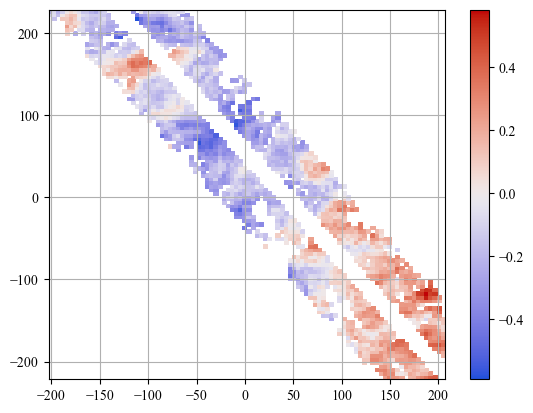

In [14]:
diff_U2H_SWOT = hs_over_Hs0_vd*Hs0 + Hs0 - hs_swot_c
diff_U2H_SWOT.shape

plt.pcolor(x_grid, y_grid, diff_U2H_SWOT, cmap=cc.cm.coolwarm)
plt.colorbar()
plt.grid()
plt.show()

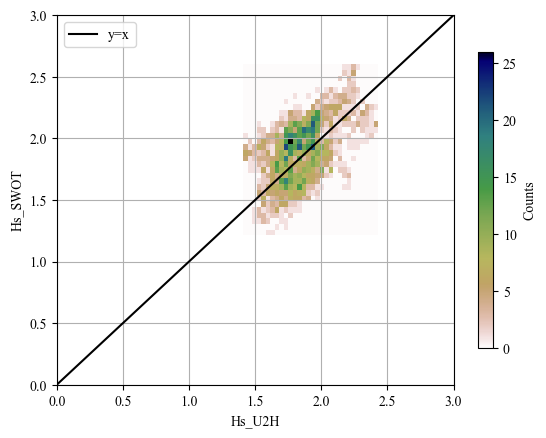

In [15]:
# DENSITY SCATTERPLOT REPLACEMENT
#plt.scatter(hs_over_Hs0[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo].T*Hs0 + Hs0, hs_swot_c)
x_hist = (hs_over_Hs0_vd * Hs0 + Hs0).ravel()
y_hist = hs_swot_c.ravel()  # or reshape if needed
mask = np.isfinite(x_hist) & np.isfinite(y_hist)
x_clean = x_hist[mask]
y_clean = y_hist[mask]
plt.hist2d(x_clean, y_clean, bins=30, cmap='gist_earth_r')
#plt.hist2d(hs_over_Hs0[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo].T*Hs0 + Hs0, hs_swot_c, bins=30, cmap='plasma')# norm=plt.cm.colors.LogNorm())  # log scale for better visibility
plt.colorbar(label='Counts', shrink=0.8)
plt.plot(np.linspace(0,3,100),np.linspace(0,3,100),label="y=x",color="black")
plt.grid()
plt.xlabel("Hs_U2H")
plt.ylabel("Hs_SWOT")
plt.legend()
plt.xlim(0,3)
plt.ylim(0,3)
plt.show()